In [1]:
## Keras configuration

# Set KERAS backend to Theano
import os
os.environ['KERAS_BACKEND']='theano'

# Load Keras
import keras

# Load the libraries
import numpy as np

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD

Using Theano backend.


In [2]:
import pandas as pd
from functools import reduce

In [3]:
# Load Data into array

nodes = []
for x in range(0, 10):
    nodes.append(pd.read_csv('https://raw.githubusercontent.com/Amitangshu/Irradiance_sensing/master/All_Data_For_EPIC_Roof/MDA300n' + str(x+150) +'.dat',
                     error_bad_lines=False, header=1))
    print("Loaded file MDA300n"+str(x+150)+".dat")

Loaded file MDA300n150.dat
Loaded file MDA300n151.dat
Loaded file MDA300n152.dat


b'Skipping line 47729: expected 7 fields, saw 13\n'


Loaded file MDA300n153.dat
Loaded file MDA300n154.dat
Loaded file MDA300n155.dat
Loaded file MDA300n156.dat
Loaded file MDA300n157.dat
Loaded file MDA300n158.dat
Loaded file MDA300n159.dat


In [4]:
# Split TimeStamp into Date and Time columns and 

numNodes = len(nodes)
for y in range(numNodes):
    nodes[y][['DATE','TIME']] = nodes[y].TMSTAMP.str.split(expand=True)

In [5]:
# Explore data to see the distribution of irradiance values

count = []
for z in range(numNodes):
    count.append(nodes[z].IRRADIANCE.value_counts())

In [6]:
count[0].index

Float64Index([   2.92,    5.83,    8.75,   11.67,   20.42,   14.58,    35.0,
                 17.5,   55.41,   26.25,
              ...
              3094.41, 7151.27, 6602.96, 6675.88, 7256.26, 4742.24, 8026.22,
              1388.26, 3505.64, 2397.37],
             dtype='float64', length=2003)

In [7]:
# Select the 10 class values
class_values = [2.92, 8.75, 3.07, 2.81, 3.17, 8.44, 2.74, 2.98, 3.14, 3.52]

In [8]:
# Subset data by the selected class values

subset = []
for a in range(numNodes):
    subset.append(nodes[a][nodes[a].IRRADIANCE.isin(class_values)])

In [9]:
print(nodes[0].columns)

Index(['TMSTAMP', 'RECNBR', 'PARENT', 'IRRADIANCE', 'SOLAROCV', 'VBATT',
       'TEMP', 'DATE', 'TIME'],
      dtype='object')


In [10]:
# Merge the subsets

data = reduce(lambda  left,right: pd.merge(left,right,on=['TMSTAMP', 'RECNBR', 'PARENT', 'IRRADIANCE', 'SOLAROCV', 'VBATT',
       'TEMP', 'DATE', 'TIME'],how='outer'), nodes)
    

In [11]:
data.head()
print(data.size)

5528907


In [12]:
# Transform Time column into numeric (hours)
data.TIME = pd.to_timedelta(data.TIME)
data.TIME = data.TIME.dt.seconds/3600

In [13]:
# Creating labels:

# Convert the labels into categorical classification
# Class values: {2.92, 8.75, 3.07, 2.81} correspond to {0, 1, 2, 3}
data.loc[data.IRRADIANCE==2.92, 'IRRADIANCE'] = 0
data.loc[data.IRRADIANCE==8.75, 'IRRADIANCE'] = 1
data.loc[data.IRRADIANCE==3.07, 'IRRADIANCE'] = 2
data.loc[data.IRRADIANCE==2.81, 'IRRADIANCE'] = 3
data.loc[data.IRRADIANCE==3.17, 'IRRADIANCE'] = 4
data.loc[data.IRRADIANCE==8.44, 'IRRADIANCE'] = 5
data.loc[data.IRRADIANCE==2.74, 'IRRADIANCE'] = 6
data.loc[data.IRRADIANCE==2.98, 'IRRADIANCE'] = 7
data.loc[data.IRRADIANCE==3.14, 'IRRADIANCE'] = 8
data.loc[data.IRRADIANCE==3.52, 'IRRADIANCE'] = 9

In [14]:
data.head()

,TMSTAMP,RECNBR,PARENT,IRRADIANCE,SOLAROCV,VBATT,TEMP,DATE,TIME
0,2012-09-14 18:53:15,1,0,40.83,0.95,3.06,85.44,2012-09-14,18.887500
1,2012-09-14 18:55:12,2,0,40.83,0.96,3.05,85.35,2012-09-14,18.920000
2,2012-09-14 19:04:01,3,0,17.50,0.89,3.05,83.80,2012-09-14,19.066944
3,2012-09-14 19:04:59,4,0,17.50,0.88,3.06,83.57,2012-09-14,19.083056
4,2012-09-14 19:05:57,5,0,14.58,0.89,3.06,83.34,2012-09-14,19.099167


In [15]:
# Split data into three parts: training(40%), testing(30%), validation(30%)
# Use scikit-learn

import sklearn
from sklearn.model_selection import train_test_split

Train_Set, Test_Set = train_test_split(data, train_size=0.5, test_size=0.4, shuffle=True)

In [16]:
# Extract the feature columns: SOLAROCV, TEMP, TIME

X_train = np.array(Train_Set[['SOLAROCV','TEMP','TIME']]).astype('float64')
X_test = np.array(Test_Set[['SOLAROCV','TEMP','TIME']]).astype('float64')

# Input Shape
shape_ord = (X_train[0].shape)

In [17]:
# Extract the label column: IRRADIANCE

# Cast the label as integer
Y_train = np.array(Train_Set[['IRRADIANCE']]).astype('int')
Y_test = np.array(Test_Set[['IRRADIANCE']]).astype('int')

from keras.utils import to_categorical
# Convert the labels into categorical form
Y_train = to_categorical(Y_train, num_classes=8750)
Y_test = to_categorical(Y_test, num_classes=8750)

In [18]:
shape_ord

(3,)

### Training Model 1 - CNN

**1.** Initialize the parameters

In [19]:
# Initialize the parameters
# Number of epochs
nb_epochs = 1
# Batch size
batch_size = 128
# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

**2.** Compile the model

In [20]:
model = Sequential()

model.add(Dense(10, activation='relu', input_dim=3))
model.add(Dropout(1.0))
model.add(Dense(10, activation='relu'))
model.add(Dropout(1.0))
model.add(Dense(8750, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

**3.** Fit the model

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                40        
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8750)              96250     
Total params: 96,400
Trainable params: 96,400
Non-trainable params: 0
_________________________________________________________________


In [22]:
hist = model.fit(X_train, Y_train, batch_size=batch_size,validation_split=0.33, 
                 epochs=nb_epochs, verbose=1, 
                 validation_data=(X_test, Y_test))

Train on 307161 samples, validate on 245730 samples
Epoch 1/1
307161/307161 [==============================] - 361s 1ms/step - loss: 5.5083 - acc: 0.1106 - val_loss: 4.9646 - val_acc: 0.1139


**4.** Visualize the results

KeyError: 'accuracy'

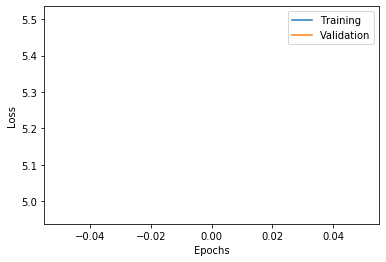

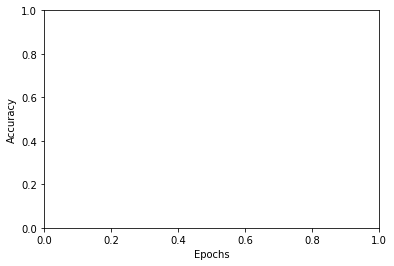

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')

**5.** Evaluate the accuracy of the model

In [ ]:
# Evaluating the model on the test data    
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)